<a href="https://colab.research.google.com/github/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo09_RandomizedKaczmarz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Randomized Kaczmarz Algoritihm

Demonstration of the basic Randomized Kaczmarz Algorithm 
 (cf. ["A Randomized Kaczmarz Algorithm with Exponential Convergence"](http://www.springerlink.com/index/10.1007/s00041-008-9030-4)
   by Strohmer and Vershynin, 2008 )

This solves **overdetermined**, **consistent** systems of linear equations
$$ Ax=b $$
where $A$ is $M\times N$ (so $M\ge N$).

For fancier versions, see:
- "Acceleration of randomized Kaczmarz method via the
Johnson?Lindenstrauss Lemma" by Y. Eldar and D. Needell 2011
- "Paved with good intentions: analysis of a randomized block kaczmarz
method" by D. Needell and J. Tropp 2012
- "Stochastic gradient descent, weighted sampling, and the randomized
Kaczmarz algorithm" by D. Needell, N. Srebro and R. Ward 2016

Code: Stephen Becker 2019 (Matlab), 2021 (Python)

In [75]:
import numpy as np
import numpy.linalg
from numpy.random import default_rng
rng = default_rng()
import scipy.linalg
from matplotlib import pyplot as plt

In [173]:
M, N = int(3e5), int(1e2)

# A   = rng.standard_normal( (M,N)) # this is well-conditioned

# This case is much harder...
A   = rng.standard_normal( (M,N) )@np.diag(np.logspace(0,2,N))@(
    rng.standard_normal((N,N) ) + 0.9*np.eye(N) )


x0  = rng.standard_normal( (N,1))
b   = A@x0  # important: no noise, we assume the system is consistent

errFcn    = lambda x : scipy.linalg.norm( x.ravel() - x0.ravel() )

In [174]:
# Solve using classical dense method
#  [ scipy.linalg.solve(A,b) won't work since it needs a square matrix
#    so we'll ask for a least-squares solution ]
print("Solving via classical dense method")
%time xClassical, residLS, rank, singVals = np.linalg.lstsq(A,b,rcond=None)
print(f'  Condition number of A is {singVals[0]/singVals[-1]:.3e}')
print(f'  Error is {errFcn(xClassical):.3e}')

Solving via classical dense method
CPU times: user 5.66 s, sys: 207 ms, total: 5.86 s
Wall time: 3.24 s
  Condition number of A is 7.473e+03
  Error is 2.911e-13


### Try the randomized Kaczmarz approach

Classical Kaczmarz cycles through indices in order

The Strohmer/Vershynin randomized version chooses indices based on iid samples from the weighted distribution determined by the squared Euclidean norms of the rows

In [175]:
rowNorms = scipy.linalg.norm( A, ord=2, axis=1)**2
# NOTE: run this cell once without the %%timeit statement,
#   since if you run with that statement, it doesn't save
#   the value of the variables into the workspace.

In [176]:
%%timeit -o -r 1 -n 1
rowNorms = scipy.linalg.norm( A, ord=2, axis=1)**2

1 loop, best of 1: 144 ms per loop


<TimeitResult : 1 loop, best of 1: 144 ms per loop>

In [177]:
tmStructure = _
tmPreprocess = tmStructure.best

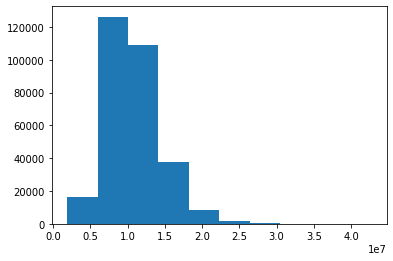

In [178]:
plt.hist( rowNorms )
plt.show()

#### Now the main iteration

In [179]:
def RK(N,wts,maxIter,blockSize=1000,tol=1e-13):

  x         = np.zeros(N) # have 1D not 2D column vector
  errList   = []

  #  We will really be taking maxIter * blockSize iterations
  #   but chose blockSize > 1 to reduce overhead costs
  for k in range(int(maxIter)):

    indList = rng.choice(M,int(blockSize),replace=True,p=wts,shuffle=True)

    for i in indList:
      res = b[i] - A[i,:].dot(x)
      x += res/rowNorms[i] * A[i,:]

    errList.append( errFcn(x) )

    if np.abs(res) > 1e100:
      print('Looks like divergence, stopping early')
      break
    if errList[-1] < tol:
      print(f'Reached tolerance, stopping early: err is {errList[-1]}')
      break

  return x, errList

In [181]:
wts = rowNorms.copy()/rowNorms.sum()
maxIter = 5e2
xRK, errList = RK( N, wts, maxIter=maxIter )

In [182]:
%%timeit -o -r 1 -n 1
# Re-run it and get the time (but the outputs are not saved)
xRK, errList = RK( N, wts, maxIter=maxIter )

1 loop, best of 1: 6.77 s per loop


<TimeitResult : 1 loop, best of 1: 6.77 s per loop>

In [183]:
tmStructure = _
tmIterative = tmStructure.best

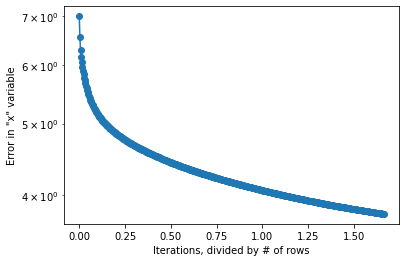

In [184]:
plt.semilogy( np.arange(0,len(errList)*blockSize,blockSize)/M, errList,'o-' )
plt.xlabel('Iterations, divided by # of rows')
plt.ylabel('Error in "x" variable')
plt.show()

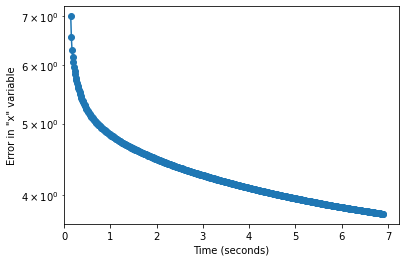

In [185]:
plt.semilogy( tmPreprocess + np.arange(len(errList))*tmIterative/len(errList), errList,'o-' )
plt.xlabel('Time (seconds)')
plt.ylabel('Error in "x" variable')
plt.xlim( left=0)
plt.show()

#### And try with an iterative solver

In [187]:
%time xLSQR, flag, iter, nrm = scipy.sparse.linalg.lsqr( A, b, show=True, iter_lim=int(1e2))[:4]

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   300000 rows  and      100 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.192e+06  1.192e+06    1.0e+00  3.1e-01
     1  3.62527e-01   6.701e+05  6.701e+05    5.6e-01  5.3e-01   4.5e+05  1.0e+00
     2  5.20243e-01   4.841e+05  4.841e+05    4.1e-01  3.6e-01   5.9e+05  2.2e+00
     3  6.44579e-01   3.936e+05  3.936e+05    3.3e-01  2.5e-01   7.3e+05  3.7e+00
     4  6.83901e-01   3.453e+05  3.453e+05    2.9e-01  2.0e-01   8.6e+05  5.3e+00
     5  8.12719e-01   2.888e+05  2.888e+05    2.4e-01  1.6e-01   9.6e+05  7.5e+00
     6  8.62026e-01   2.504e+05  2.504e+05    2.1e-01  1.4e-01   1.0e+06  9.5e+00
     7  9.55883e-01   2.018e+05  2.018e+05    1.7e-01  1.4e-01   1.1e+06  1.2e+01
     8  9.44565e-01   1.793e

In [188]:
errFcn(xLSQR)

4.231640751798826